In [1]:
import torch.nn as nn
import torch
import random
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def generate_data_files():
    if os.path.exists("DataSets/Jumble/jumbled.txt"): os.remove("DataSets/Jumble/jumbled.txt")
    if os.path.exists("DataSets/Jumble/unjumbled.txt"): os.remove("DataSets/Jumble/unjumbled.txt")   
    f1 = open("DataSets/Jumble/jumbled.txt","w")
    f2 = open("DataSets/Jumble/unjumbled.txt","w")
    with open("DataSets/Jumble/source.txt","r") as f:
        for line in f:
            split_line = line.lower().strip().split()
            sentence = split_line[1:]
            f2.write(' '.join(sentence)+"\n")
            random.shuffle(sentence)
            f1.write(" ".join(sentence)+"\n")
    f1.close()
    f2.close()

In [3]:
generate_data_files()

In [4]:
def get_count_of_words():
    word_count_dict = {}
    with open("DataSets/Jumble/jumbled.txt","r") as f:
        for line in f:
            words = line.split()
            for word in words:
                if word in word_count_dict: word_count_dict[word] += 1
                else: word_count_dict[word] = 1
    return word_count_dict

In [5]:
word_count_dict = get_count_of_words()
print(len(word_count_dict))

8918


In [6]:
min_word_count = 4
count = 0
for k,v in word_count_dict.items():
    if v > min_word_count: count += 1
print(count)

3001


In [13]:
def replace_less_frequent_words(filename,word_count_dict,min_word_count,replace_token="<unk>"):
    with open(filename,"r") as f:
        with open("DataSets/Jumble/processed_"+filename.split("/")[-1],"w") as f1:
            for line in f:
                words = line.strip().split()
                sentence_to_write = []
                for word in words:
                    if word_count_dict[word] > min_word_count: sentence_to_write.append(word)
                    else: sentence_to_write.append(replace_token)
                sentence_to_write.append("\n")
                f1.write(" ".join(sentence_to_write))

In [14]:
replace_less_frequent_words(
    "DataSets/Jumble/jumbled.txt",word_count_dict,min_word_count=min_word_count,replace_token="<unk>"
)

In [15]:
replace_less_frequent_words(
    "DataSets/Jumble/unjumbled.txt",word_count_dict,min_word_count=min_word_count,replace_token="<unk>"
)

## Classes

In [16]:
class VocabBuilder:
    def __init__(self,text_corpus,unknown_token=None,pad_token=None,sos_token=None,eos_token=None):
        '''
        text_corpus = [
            sentence_1,  # sentence_1 = "a yellow car ..."
            sentence_2
            ...
        ]
        '''
        self.text_corpus = text_corpus
        self.unknown_token = unknown_token or "<unk>"
        self.pad_token = pad_token or "<pad>"
        self.sos_token = sos_token or "<sos>"
        self.eos_token = eos_token or "<eos>"
        self.word_to_index, self.index_to_word = self.get_vocabs()
                        
    def get_vocabs(self):
        word_to_index = {}
        index_count = 0
        for sentence in self.text_corpus:
            words = sentence.split()
            for word in words:
                if word not in word_to_index:
                    word_to_index[word] = index_count
                    index_count += 1
        if not self.unknown_token in word_to_index: 
            word_to_index[self.unknown_token] = index_count
            index_count += 1
        if not self.pad_token in word_to_index: 
            word_to_index[self.pad_token] = index_count
            index_count += 1
        if not self.sos_token in word_to_index: 
            word_to_index[self.sos_token] = index_count
            index_count += 1
        if not self.eos_token in word_to_index: 
            word_to_index[self.eos_token] = index_count
            index_count += 1
        index_to_word = {v:k for k,v in word_to_index.items()}
        return word_to_index, index_to_word

In [17]:
class EncodeDecode:
    def __init__(self,word_to_index,index_to_word,pad_token,unknown_token,smallcase=True):
        self.smallcase = smallcase
        self.word_to_index = word_to_index
        self.index_to_word = index_to_word
        self.pad_token = pad_token
        self.unknown_token = unknown_token
    
    def get_encoding(self,sentence):
        '''
        sentence can be a string, or a list of words
        '''
        if isinstance(sentence,str): sentence = sentence.split(" ")
        if self.smallcase: sentence =  [word.lower() for word in sentence]
        encoded_sentence = []
        for word in sentence:
            if word in self.word_to_index: encoded_sentence.append(self.word_to_index[word])
            else: encoded_sentence.append(self.word_to_index[self.unknown_token])
        return encoded_sentence
    
    def get_decoding(self,encoded_sentence):
        '''
        encoded_sentence must be a list of vocab indices.
        Ex: encoded_sentence = [24,21,4,1,..] 
        '''
        sentence = [self.index_to_word[index] for index in encoded_sentence]
        return " ".join(sentence)

In [18]:
class UnjumbleEncoderModel(nn.Module):
    def __init__(self,vocab_size,embedding_dim,num_lstm_layers,hidden_size,make_bidirectional,debug):
        super().__init__()
        self.debug = debug
        self.bidirectional = make_bidirectional
        self.num_lstm_layers = num_lstm_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(input_size=embedding_dim,hidden_size=hidden_size,dropout=0.5,
                            num_layers=num_lstm_layers,bidirectional=make_bidirectional,batch_first=True)
        
    def forward(self,x,h):
        if self.debug: 
            print("_______________________________")
            print("\t\tEncoder\t\t")
            print("_______________________________")
        if self.debug: print("Before starting: x Shape:",x.shape,"Prev State Shape",h.shape)
        
        x = self.embedding(x)
        x = self.relu(x)
        if self.debug: print("Embedding, x Shape:",x.shape)
        
        op,ht = self.gru(x,h)
        if self.debug: print("GRU, op Shape:",op.shape,"ht shape",ht.shape)
        
        if self.bidirectional: 
            ht_for_decoder = torch.cat((ht[-1],ht[-2]),axis=1)
            ht_for_decoder = ht_for_decoder.unsqueeze(0)
        else: ht_for_decoder = ht[-1].unsqueeze(0)
        if self.debug: print("ht for decoder shape",ht_for_decoder.shape)
            
        return op,ht,ht_for_decoder
    
    def init_hidden(self):
        first_param = self.num_lstm_layers
        if self.bidirectional: first_param *= 2
        return torch.zeros(first_param, 1, self.hidden_size)

class UnjumbleBahadnauAttention(nn.Module):
    def __init__(self,attention_neurons,debug):
        super().__init__()
        self.debug = debug
        self.rnn = nn.RNNCell(input_size=attention_neurons,hidden_size=attention_neurons,bias=False)
        self.linear = nn.Linear(in_features = attention_neurons, out_features = 1)
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self,op_from_enoder,st_minus_one_from_decoder):
        
        # Reshape the op_from_enoder from (batch_size,seq_length,lstm_neurons) to (batch_size*seq_length,lstm_neurons)
        # And reshape st_minus_one_from_decoder from (1,batch_size,lstm_neurons) to (batch_size,lstm_neurons)
        # And repeat st_minus_one_from_decoder to seq_length times to get (batch_size*seq_length,lstm_neurons)
        if self.debug: 
            print("_______________________________")
            print("\t\tAttention\t\t")
            print("_______________________________")
        seq_length = op_from_enoder.shape[1]
        op_from_enoder = op_from_enoder.reshape(-1,op_from_enoder.shape[2])
        st_minus_one_from_decoder = st_minus_one_from_decoder[-1]
        st_minus_one_from_decoder = st_minus_one_from_decoder.repeat(seq_length,1)
        if self.debug: print("Shape of op_from_encoder:",op_from_enoder.shape,
                             "Shape of st_minus_one_from_decoder:",st_minus_one_from_decoder.shape)
            
        rnn_op = self.rnn(op_from_enoder,st_minus_one_from_decoder)
        if self.debug: print("RNN Cell Op:",rnn_op.shape)
            
        linear_op = self.linear(rnn_op)
        if self.debug: print("Linear Op:",linear_op.shape)
            
        softmax_op = self.softmax(linear_op)
        if self.debug: print("Softmax Op:",softmax_op.shape)
            
        ct = torch.sum(torch.mul(op_from_enoder,softmax_op),dim=0).unsqueeze(0)
        if self.debug: print("Weighted Averaged h vectors:",ct.shape)
        
        return ct,softmax_op
        

class UnjumbleDecoderModel(nn.Module):
    def __init__(self,model_attention,vocab_size,embedding_dim,num_lstm_layers,
                 hidden_size,make_bidirectional,debug):
        super().__init__()
        self.debug = debug
        self.model_attention = model_attention
        self.bidirectional = make_bidirectional
        self.num_lstm_layers = num_lstm_layers
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.relu = nn.ReLU()
        self.gru_input_size = embedding_dim  + hidden_size
        self.gru = nn.GRU(input_size=self.gru_input_size,hidden_size=hidden_size,
                            num_layers=num_lstm_layers,bidirectional=make_bidirectional,batch_first=True)
        self.in_features = hidden_size*2 if make_bidirectional else hidden_size
        self.linear = nn.Linear(in_features=self.in_features, out_features=vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,x,s0_from_encoder,op_from_encoder_for_attn):
        if self.debug: 
            print("_______________________________")
            print("\t\tDecoder\t\t")
            print("_______________________________")
        if self.debug: print("Before starting: x Shape:",x.shape," s0_from_encoder Shape:",s0_from_encoder.shape)
        
        x = self.embedding(x)
        x = self.relu(x)
        if self.debug: print("Embedding, x Shape:",x.shape)
        
        
        seq_length = x.shape[1]
        if self.debug: print("Sequence Length:",seq_length)
        
        all_timestep_op = []
        for i in range(seq_length):
            if i == 0: 
                ct,softmax_op = self.model_attention(op_from_encoder_for_attn,s0_from_encoder)
                concatenated_x = torch.cat((x[0][i].unsqueeze(0),ct),axis=1)
                if self.debug: print("concatenated_x shape:",concatenated_x.shape)
                gru_op,ht = self.gru(concatenated_x.unsqueeze(0),s0_from_encoder)
                
            else: 
                ct,softmax_op = self.model_attention(op_from_encoder_for_attn,ht)
                concatenated_x = torch.cat((x[0][i].unsqueeze(0),ct),axis=1)
                if self.debug: print("concatenated_x shape:",concatenated_x.shape)
                gru_op,ht = self.gru(concatenated_x.unsqueeze(0),ht)
            
            all_timestep_op.append(gru_op)
            if self.debug:
                print("---------------------------------")
                print("GRU_OP:",gru_op.shape,"Ht:",ht.shape)
                print("---------------------------------")
        
        gru_final_op = torch.cat(all_timestep_op,axis=1)
        if self.debug: print("GRU, Final Shape:",gru_final_op.shape,"ht shape",ht.shape)
            
        # Resizing caption for Linear Layer
        gru_final_op = gru_final_op.reshape(-1,gru_final_op.shape[2])
        if self.debug: print("Reshaping gru_final_op Shape:",gru_final_op.shape)
        
        linear_op = self.linear(gru_final_op)
        if self.debug: print("Linear linear_op Shape:",linear_op.shape)
        
        op = self.log_softmax(linear_op)
        if self.debug: print("log_softmax op Shape:",op.shape)
            
        if self.debug:print("_______________________________\n\n")
            
        return op,ht,softmax_op


### Putting it all together

In [19]:
unknown_token = "<unk>"
pad_token = "<pad>"
sos_token = "<sos>"
eos_token = "<eos>"
Xe,Xd,Y = [],[],[]
with open("DataSets/Jumble/processed_jumbled.txt","r") as f:
    for line in f:
        Xe.append(line.strip()+" " +eos_token)
with open("DataSets/Jumble/processed_unjumbled.txt","r") as f:
    for line in f:
        Xd.append(sos_token+" "+line.strip())
        Y.append(line.strip()+" " +eos_token)
print(len(Xe),len(Xd),len(Y))

40460 40460 40460


In [20]:
Xtr_e, Xval_e, Xtr_d, Xval_d, Ytr, Yval = train_test_split(Xe,Xd,Y,test_size=0.1,random_state=20)
print(len(Xtr_e), len(Xval_e), len(Xtr_d), len(Xval_d), len(Ytr), len(Yval))
encoder_vocab_builder = VocabBuilder(Xtr_e,unknown_token=unknown_token,pad_token=pad_token,sos_token=sos_token,eos_token=eos_token)
decoder_vocab_builder = VocabBuilder(Xtr_d,unknown_token=unknown_token,pad_token=pad_token,sos_token=sos_token,eos_token=eos_token)
encoder_wtoi,encoder_itow = encoder_vocab_builder.word_to_index, encoder_vocab_builder.index_to_word
decoder_wtoi,decoder_itow = decoder_vocab_builder.word_to_index, decoder_vocab_builder.index_to_word
len(encoder_itow),len(encoder_wtoi),len(decoder_wtoi),len(decoder_itow)

36414 4046 36414 4046 36414 4046


(3005, 3005, 3005, 3005)

In [21]:
device = torch.device("cuda:0")
hidden_size_encoder = 400
hidden_size_decoder = hidden_size_encoder
model_encoder = UnjumbleEncoderModel(
    vocab_size=len(encoder_wtoi),embedding_dim=300,num_lstm_layers=2,
    hidden_size=hidden_size_encoder,make_bidirectional=True,debug=True
).to(device)
if model_encoder.bidirectional: hidden_size_decoder = 2*hidden_size_encoder
model_attention = UnjumbleBahadnauAttention(hidden_size_decoder,debug=True).to(device)
model_decoder = UnjumbleDecoderModel(
    model_attention = model_attention,
    vocab_size=len(encoder_wtoi),embedding_dim=300,num_lstm_layers=1,
    hidden_size=hidden_size_decoder,make_bidirectional=False,debug=True
).to(device)
loss_fn = nn.NLLLoss()
optimizer_encoder = torch.optim.Adam(model_encoder.parameters(),lr=0.003)
optimizer_decoder = torch.optim.Adam(model_decoder.parameters(),lr=0.003)

In [22]:
data_index = 6
encoder_encode_decode = EncodeDecode(encoder_wtoi,encoder_itow,pad_token,unknown_token)
decoder_encode_decode = EncodeDecode(decoder_wtoi,decoder_itow,pad_token,unknown_token)
print(Xtr_e[data_index],encoder_encode_decode.get_encoding(Xtr_e[data_index]))
print(Xtr_d[data_index],decoder_encode_decode.get_encoding(Xtr_d[data_index]))
print(Ytr[data_index],decoder_encode_decode.get_encoding(Ytr[data_index]))

init_ht_for_encoder = model_encoder.init_hidden().to(device)
model_encoder.train()
model_decoder.train()

optimizer_encoder.zero_grad()
optimizer_decoder.zero_grad()
Xe_b = torch.tensor([encoder_encode_decode.get_encoding(Xtr_e[data_index])]).to(device)
Xd_b = torch.tensor([decoder_encode_decode.get_encoding(Xtr_d[data_index])]).to(device)
Y_b = torch.tensor([decoder_encode_decode.get_encoding(Ytr[data_index])]).to(device)
print(Xe_b.shape,Xd_b.shape,Y_b.shape)
op_from_encoder,ht,ht_for_decoder = model_encoder(Xe_b,init_ht_for_encoder)
op,_,_ = model_decoder(Xd_b,ht_for_decoder,op_from_encoder)
ht = ht.detach()
loss = loss_fn(op,Y_b.reshape(-1))
loss.backward()
optimizer_encoder.step()
optimizer_decoder.step()

print("---------------------------------------------")

optimizer_encoder.zero_grad()
optimizer_decoder.zero_grad()
Xe_b = torch.tensor([encoder_encode_decode.get_encoding(Xtr_e[data_index+1])]).to(device)
Xd_b = torch.tensor([decoder_encode_decode.get_encoding(Xtr_d[data_index+1])]).to(device)
Y_b = torch.tensor([decoder_encode_decode.get_encoding(Ytr[data_index+1])]).to(device)
print(Xe_b.shape,Xd_b.shape,Y_b.shape)
op_from_encoder,ht,ht_for_decoder = model_encoder(Xe_b,ht)
op,_,_ = model_decoder(Xd_b,ht_for_decoder,op_from_encoder)
ht = ht.detach()
loss = loss_fn(op,Y_b.reshape(-1))
loss.backward()
optimizer_encoder.step()
optimizer_decoder.step()

. man snowy a mountain descends a <eos> [7, 47, 48, 13, 49, 50, 13, 9]
<sos> a man descends a snowy mountain . [0, 10, 47, 48, 10, 49, 50, 9]
a man descends a snowy mountain . <eos> [10, 47, 48, 10, 49, 50, 9, 3004]
torch.Size([1, 8]) torch.Size([1, 8]) torch.Size([1, 8])
_______________________________
		Encoder		
_______________________________
Before starting: x Shape: torch.Size([1, 8]) Prev State Shape torch.Size([4, 1, 400])
Embedding, x Shape: torch.Size([1, 8, 300])
GRU, op Shape: torch.Size([1, 8, 800]) ht shape torch.Size([4, 1, 400])
ht for decoder shape torch.Size([1, 1, 800])
_______________________________
		Decoder		
_______________________________
Before starting: x Shape: torch.Size([1, 8])  s0_from_encoder Shape: torch.Size([1, 1, 800])
Embedding, x Shape: torch.Size([1, 8, 300])
Sequence Length: 8
_______________________________
		Attention		
_______________________________
Shape of op_from_encoder: torch.Size([8, 800]) Shape of st_minus_one_from_decoder: torch.Size(

In [23]:
def predict(model_encoder,model_decoder,encoder_encode_decode,decoder_itow,decoder_wtoi):
    data_index = random.randint(0,100)
    Xe_b = torch.tensor([encoder_encode_decode.get_encoding(Xval_e[data_index])]).to(device)
    print(Xval_e[data_index],Xe_b)
    print(Xval_d[data_index])
    
    model_encoder.eval()
    model_decoder.eval()
    with torch.no_grad():
        softmax_ops = []
        init_ht_for_encoder = model_encoder.init_hidden().to(device)
        op_from_encoder,ht,ht_for_decoder = model_encoder(Xe_b,init_ht_for_encoder)
        sos_word = torch.tensor([[decoder_wtoi["<sos>"]]]).to(device)
        op,ht,softmax_op = model_decoder(sos_word,ht_for_decoder,op_from_encoder)
        softmax_ops.append([round(float(el),3) for el in softmax_op.cpu()])
        unjumbled_sentence = []
        for i in range(25):
            predicted_word = torch.argmax(op,axis=1).tolist()
#             print("Predicted .....................",predicted_word)
            unjumbled_sentence.append(decoder_itow[predicted_word[0]])
            if predicted_word[0] == decoder_wtoi["<eos>"]: break
            op,ht,softmax_op = model_decoder(torch.tensor([predicted_word]).to(device),ht,op_from_encoder)
            softmax_ops.append([round(float(el),3) for el in softmax_op.cpu()])
        print("_______________________________________")
        print(unjumbled_sentence)
        print("attention weights")
        df = pd.DataFrame(softmax_ops)
        if df.shape[0] == len(unjumbled_sentence):
            jumbled_words = Xval_e[data_index].split()
            df.columns = jumbled_words
            df.index = unjumbled_sentence
            plt.figure(figsize=(16,4))
            sns.heatmap(df, annot=True)
            plt.show()
        print("_______________________________________")

while in the jacket three wears dogs dog . a playing one snow <eos> tensor([[137,  11,   4, 764,  97, 821,  73,  52,   7,  13, 155,  95, 122,   9]],
       device='cuda:0')
<sos> three dogs playing in the snow while one dog wears a jacket .
_______________________________
		Encoder		
_______________________________
Before starting: x Shape: torch.Size([1, 14]) Prev State Shape torch.Size([4, 1, 400])
Embedding, x Shape: torch.Size([1, 14, 300])
GRU, op Shape: torch.Size([1, 14, 800]) ht shape torch.Size([4, 1, 400])
ht for decoder shape torch.Size([1, 1, 800])
_______________________________
		Decoder		
_______________________________
Before starting: x Shape: torch.Size([1, 1])  s0_from_encoder Shape: torch.Size([1, 1, 800])
Embedding, x Shape: torch.Size([1, 1, 300])
Sequence Length: 1
_______________________________
		Attention		
_______________________________
Shape of op_from_encoder: torch.Size([14, 800]) Shape of st_minus_one_from_decoder: torch.Size([14, 800])
RNN Cell Op: torc

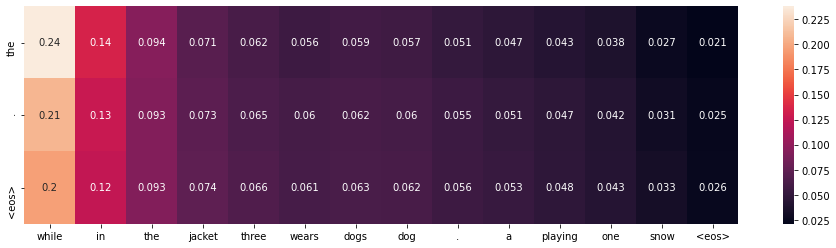

_______________________________________


In [24]:
predict(model_encoder,model_decoder,encoder_encode_decode,decoder_itow,decoder_wtoi)

## For Actual Training

In [25]:
device = torch.device("cuda:0")
hidden_size_encoder = 400
hidden_size_decoder = hidden_size_encoder
model_encoder = UnjumbleEncoderModel(
    vocab_size=len(encoder_wtoi),embedding_dim=300,num_lstm_layers=2,
    hidden_size=hidden_size_encoder,make_bidirectional=True,debug=False
).to(device)
if model_encoder.bidirectional: hidden_size_decoder = 2*hidden_size_encoder
model_attention = UnjumbleBahadnauAttention(hidden_size_decoder,debug=False).to(device)
model_decoder = UnjumbleDecoderModel(
    model_attention = model_attention,
    vocab_size=len(encoder_wtoi),embedding_dim=300,num_lstm_layers=1,
    hidden_size=hidden_size_decoder,make_bidirectional=False,debug=False
).to(device)
loss_fn = nn.NLLLoss()
optimizer_encoder = torch.optim.Adam(model_encoder.parameters(),lr=0.0003)
optimizer_decoder = torch.optim.Adam(model_decoder.parameters(),lr=0.0003)
epochs = 10

In [ ]:
for i in range(epochs):
    init_ht_for_encoder = model_encoder.init_hidden().to(device)
    model_encoder.train()
    model_decoder.train()
    epoch_loss = 0
    for j in range(len(Xtr_e)):
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        Xe_b = torch.tensor([encoder_encode_decode.get_encoding(Xtr_e[j])]).to(device)
        Xd_b = torch.tensor([decoder_encode_decode.get_encoding(Xtr_d[j])]).to(device)
        Y_b = torch.tensor([decoder_encode_decode.get_encoding(Ytr[j])]).to(device)
        op_from_encoder,ht,ht_for_decoder = model_encoder(Xe_b,init_ht_for_encoder)
        op,_,_ = model_decoder(Xd_b,ht_for_decoder,op_from_encoder)
#         ht = ht.detach()
#         init_ht_for_encoder = ht
        loss = loss_fn(op,Y_b.reshape(-1))
        loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()
        batch_loss = loss.item()
        epoch_loss += batch_loss
        if j%2000 == 0: print("Epoch:",i,"Batch:",j,"Loss:",batch_loss)
    print("______________________________________")
    print("Epoch Loss:",epoch_loss)
    predict(model_encoder,model_decoder,encoder_encode_decode,decoder_itow,decoder_wtoi)
    print("_______________________________________")

In [ ]:
def predict_on_whole_val(model_encoder,model_decoder,encoder_encode_decode,decoder_itow,decoder_wtoi):
    model_encoder.eval()
    model_decoder.eval()
    accuracy_tuple_list = []  #[(jumbed_sent,unjumbled_sent,predicted_sent,hard,soft,word_count),...,]
    with torch.no_grad():
        for data_index in range(len(Xval_e)):
            if data_index % 50 == 0: print(data_index,end = ' ')
            Xe_b = torch.tensor([encoder_encode_decode.get_encoding(Xval_e[data_index])]).to(device)

            init_ht_for_encoder = model_encoder.init_hidden().to(device)
            op_from_encoder,ht,ht_for_decoder = model_encoder(Xe_b,init_ht_for_encoder)
            sos_word = torch.tensor([[decoder_wtoi["<sos>"]]]).to(device)
            op,ht,softmax_op = model_decoder(sos_word,ht_for_decoder,op_from_encoder)
            unjumbled_sentence = []
            for i in range(25):
                predicted_word = torch.argmax(op,axis=1).tolist()
                unjumbled_sentence.append(decoder_itow[predicted_word[0]])
                if predicted_word[0] == decoder_wtoi["<eos>"]: break
                op,ht,softmax_op = model_decoder(torch.tensor([predicted_word]).to(device),ht,op_from_encoder)
                
            hard_accuracy = 1 if " ".join(unjumbled_sentence) == Yval[data_index] else 0
            word_count = len(set(Yval[data_index].split()))
            soft_accuracy = len(set(unjumbled_sentence).intersection(set(Yval[data_index].split())))/word_count
            accuracy_tuple_list.append(
                (Xval_e[data_index],Yval[data_index]," ".join(unjumbled_sentence),hard_accuracy,soft_accuracy,word_count)
            )
    return accuracy_tuple_list

In [ ]:
accuracy_tuple_list = predict_on_whole_val(model_encoder,model_decoder,encoder_encode_decode,decoder_itow,decoder_wtoi)
df = pd.DataFrame(accuracy_tuple_list)
df.columns = ["jumbled_sent","unjumbled_sent","prediction","hard_accuracy","soft_accuracy","word_count"]
print(df.shape,df['hard_accuracy'].sum())
df.head(10)

In [ ]:
a = sum((df['soft_accuracy']*df['word_count']).tolist())
b = df['word_count'].sum()
a,b,a/b

In [26]:
def predict_on_test(model_encoder_new,model_decoder_new,encoder_encode_decode,decoder_itow,decoder_wtoi):
    model_encoder.eval()
    model_decoder.eval()
    accuracy_tuple_list = []  #[(jumbed_sent,unjumbled_sent,predicted_sent,hard,soft,word_count),...,]
    with torch.no_grad():
        for data_index in range(len(Xtest_e)):
            if data_index % 50 == 0: print(data_index,end = ' ')
            Xe_b = torch.tensor([encoder_encode_decode.get_encoding(Xtest_e[data_index])]).to(device)

            init_ht_for_encoder = model_encoder_new.init_hidden().to(device)
            op_from_encoder,ht,ht_for_decoder = model_encoder_new(Xe_b,init_ht_for_encoder)
            sos_word = torch.tensor([[decoder_wtoi["<sos>"]]]).to(device)
            op,ht,softmax_op = model_decoder_new(sos_word,ht_for_decoder,op_from_encoder)
            unjumbled_sentence = []
            for i in range(25):
                predicted_word = torch.argmax(op,axis=1).tolist()
                unjumbled_sentence.append(decoder_itow[predicted_word[0]])
                if predicted_word[0] == decoder_wtoi["<eos>"]: break
                op,ht,softmax_op = model_decoder_new(torch.tensor([predicted_word]).to(device),ht,op_from_encoder)
            hard_accuracy = 1 if " ".join(unjumbled_sentence) == Ytest[data_index] else 0
            word_count = len(set(Ytest[data_index].split()))
            soft_accuracy = len(set(unjumbled_sentence).intersection(set(Ytest[data_index].split())))/word_count
            accuracy_tuple_list.append(
                (Xtest_e[data_index],Ytest[data_index]," ".join(unjumbled_sentence),hard_accuracy,soft_accuracy,word_count)
            )
    return accuracy_tuple_list

In [27]:
Xtest_e = [
    "is eating . Nitish apple <eos>",
    "is city my favorite New York. <eos>",
    "a a and dog are man woods walking through the . <eos>"
]
Ytest = [
    "Nitish is eating apple . <eos>",
    "New York is my faorite city. <eos>",
    "a man and a dog are walking through the woods . <eos>"
]

In [ ]:
accuracy_tuple_list_test = predict_on_test(model_encoder,model_decoder,encoder_encode_decode,decoder_itow,decoder_wtoi)
df_test = pd.DataFrame(accuracy_tuple_list_test)
df_test.columns = ["jumbled_sent","unjumbled_sent","prediction","hard_accuracy","soft_accuracy","word_count"]
df_test.head(10)

## Save the models

#### Attention Model was not required to be saved explicitly as it is a part of the decoder model only.
#### Additionally the word_to_index and index_to_word dictionary and get_encoding funtion will be required for inference

In [ ]:
torch.save(model_encoder,"SavedModels/Jumble/encoder_model.pt")
torch.save(model_attention,"SavedModels/Jumble/attention_model.pt")
torch.save(model_decoder,"SavedModels/Jumble/decoder_model.pt")

## Load Saved Models

In [31]:
loaded_encoder_model = torch.load("SavedModels/Jumble/encoder_model.pt")
loaded_decoder_model = torch.load("SavedModels/Jumble/decoder_model.pt")
model_attention = torch.load("SavedModels/Jumble/attention_model.pt")

In [32]:
accuracy_tuple_list_test = predict_on_test(loaded_encoder_model,loaded_decoder_model,encoder_encode_decode,decoder_itow,decoder_wtoi)
df_test = pd.DataFrame(accuracy_tuple_list_test)
df_test.columns = ["jumbled_sent","unjumbled_sent","prediction","hard_accuracy","soft_accuracy","word_count"]
df_test.head(10)

0 

,jumbled_sent,unjumbled_sent,prediction,hard_accuracy,soft_accuracy,word_count
0,is eating . Nitish apple <eos>,Nitish is eating apple . <eos>,the line <unk> fish her fish <eos>,0,0.166667,6
1,is city my favorite New York. <eos>,New York is my faorite city. <eos>,her <unk> <unk> city <unk> <eos>,0,0.142857,7
2,a a and dog are man woods walking through the ...,a man and a dog are walking through the woods ...,man walks through two soccer men sits <eos>,0,0.272727,11
